# San Francisco Crime Classification

Authors: Chiara Angileri, Livia Del Gaudio, Giorgia Pavani

### Import libraries

In [ ]:
!pip install scikit-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql.functions import *

from pyspark.ml.feature import *
from pyspark.ml import Pipeline

from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes, LogisticRegression, RandomForestClassifier

from sklearn.metrics import log_loss
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#fix seed for reproducibility
seed = 1234


In [3]:
#Geopandas
!pip3 install geopandas
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

# Load the data

In [38]:
def load_data(split):
    df = spark.read.format("csv")\
                    .option("sep", ",")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path",f"bigdata/Project/dataset/{split}.csv").load()
    return df

In [39]:
df_sfcrime = load_data("train")
df_sfcrime.printSchema()

In [41]:
# Visualize the data
df_sfcrime.show(5)

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

## Data Preprocessing

Steps done in preprocessing:
- feature extraction
- drop duplicate rows
- null removal
- outliers removal

In [ ]:
def plot_outliers(df):
    sfcrime_pd = df.toPandas()

    geometry = [Point(xy) for xy in zip(sfcrime_pd['X'], sfcrime_pd['Y'])]
    gdf = GeoDataFrame(sfcrime_pd, geometry=geometry)

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf.plot(ax=world.plot(), marker='o', color='red')
    plt.show()

In [42]:
# Extract features from date 
df_sfcrime = df_sfcrime.withColumn('Hour', hour("Dates"))\
        .withColumn('Month', month("Dates"))\
        .withColumn('Year', year("Dates"))

# Drop duplicate rows
prev_count = df_sfcrime.count()
df_sfcrime = df_sfcrime.dropDuplicates()
print(f"Number of duplicated rows: ", prev_count - df_sfcrime.count())

# Nulls removal
df_sfcrime.na.drop()

# Outliers removal
plot_outliers(df_sfcrime) 
prev_count = df_sfcrime.count()
sfcrime = df_sfcrime.where((df_sfcrime.X < -122) & (df_sfcrime.X > -123) & (df_sfcrime.Y < 38) & (df_sfcrime.Y > 37))
print(f"Number of outliers: ", prev_count - sfcrime.count())
    
# Normalize X, Y coordinates 
for i in ["X","Y"]:
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")
    pipeline = Pipeline(stages=[assembler, scaler])
    df_sfcrime = pipeline.fit(df_sfcrime).transform(df_sfcrime)

# Drop unused columns
df_sfcrime = df_sfcrime.drop("Dates")
df_sfcrime = df_sfcrime.drop("X_Vect","Y_Vect", "X", "Y")

# Visualize the data
df_sfcrime.show()

Number of duplicated rows:  2323


Number of outliers:  67


From the previous image, we can observe that there are some erroneus coordinates that do not refer to San Francisco geographic coordinates. They may be due to mislabelling errors, and we consider them as outliers, therefore we remove them from the dataset. 

## Dataset inspection

In [28]:
# split the data into train and test (for inspection of the train set)
sfcrime_train, sfcrime_test = df_sfcrime.randomSplit([0.7, 0.3], seed=seed)

In [13]:
plot = True
if plot:
    sfcrime_train_pd = sfcrime_train.toPandas().copy()
    
    # Select the top 10 crimes and group the rest into 'Other crimes'
    top10 = sfcrime_train_pd['Category'].value_counts().head(10).index.tolist()
    sfcrime_train_top_10 = sfcrime_train_pd.copy()
    sfcrime_train_top_10.loc[~sfcrime_train_pd['Category'].isin(top10), 'Category'] = 'Other crimes'


### Distribution of crimes

In [18]:
def crime_distribution(df, plot = True):
    if plot:
        df.groupBy("Category").count().orderBy("count", ascending=False).toPandas().plot(kind='bar', x='Category', y='count', log=True, figsize=(20,10))
        plt.title('Distribution of crimes')
        plt.show()

crime_distribution(sfcrime_train, plot = plot)    

### Distributions of crimes among districts

In [19]:
def crime_distribution_among_districts(df, df_copy_top_10, plot = True):
    if plot:
        df.groupBy("PdDistrict").count().orderBy("count", ascending=False).toPandas().plot(kind='bar', x='PdDistrict', y='count', figsize=(10,5))
        plt.title('Distribution of crimes among districts')
        plt.xlabel('Districts')
        plt.show()
        
        # Analyze the different categories of crimes per district
        df_copy_top_10.groupby(['PdDistrict','Category'])\
                    .agg({'Resolution':'count'})\
                    .pivot_table(index='PdDistrict',columns='Category')['Resolution']\
                    .plot(kind='bar',stacked=True,figsize=(12,8))
        plt.title('Distribution of crimes among districts')

crime_distribution_among_districts(sfcrime_train, sfcrime_train_top_10, plot = plot)

NameError: name 'sfcrime_train_top_10' is not defined

### Distribution of crimes among years

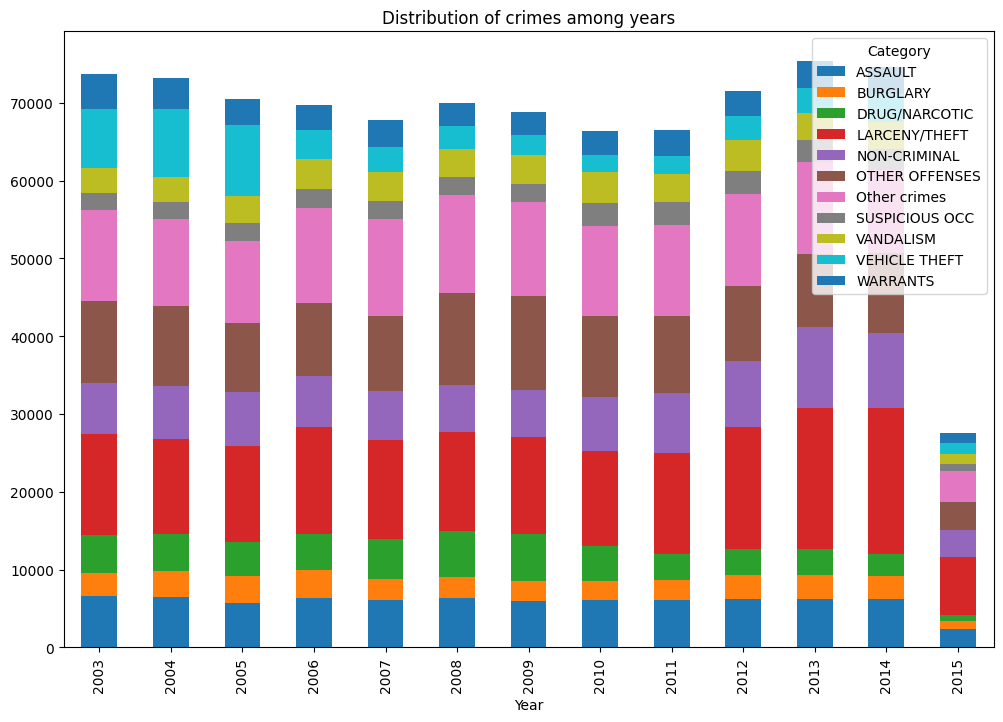

In [ ]:
def crime_distribution_among_years(df_copy_top_10, plot = True):
    if plot:
        df_copy_top_10.groupby(['Year','Category'])\
                        .agg({'Resolution':'count'})\
                        .pivot_table(index='Year',columns='Category')['Resolution']\
                        .plot(kind='bar',stacked=True,figsize=(12,8))

        plt.title('Distribution of crimes among years')
        plt.show()

crime_distribution_among_years(sfcrime_train_top_10, plot = plot)

In 2015 there is a drop in the number of crimes because the dataset contains the crimes until may 2015. 

### Distribution of crimes among hours

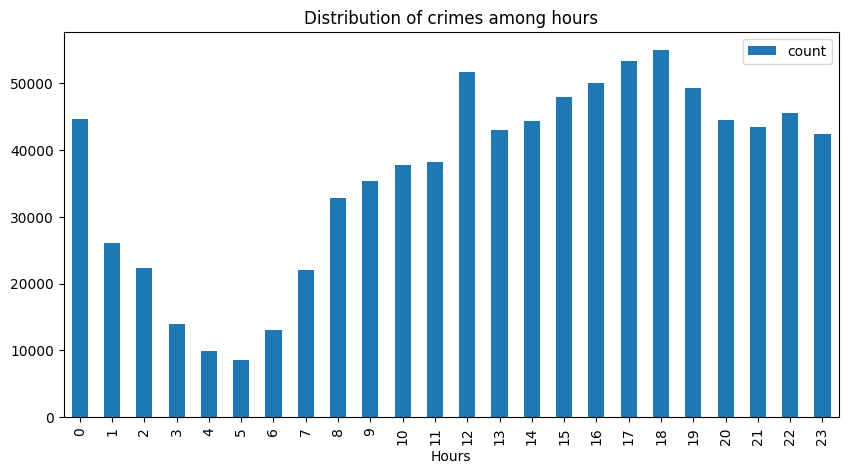

In [ ]:
def crime_distribution_among_hours(df, plot = True):
    if plot:
        df.groupBy("Hour").count().orderBy("hour", ascending=True).toPandas().plot(kind='bar', x='Hour', y='count', figsize=(10,5))
        plt.title('Distribution of crimes among hours')
        plt.xlabel('Hours')
        plt.show()

crime_distribution_among_hours(sfcrime_train, plot = plot)

### Distribution of crimes among days

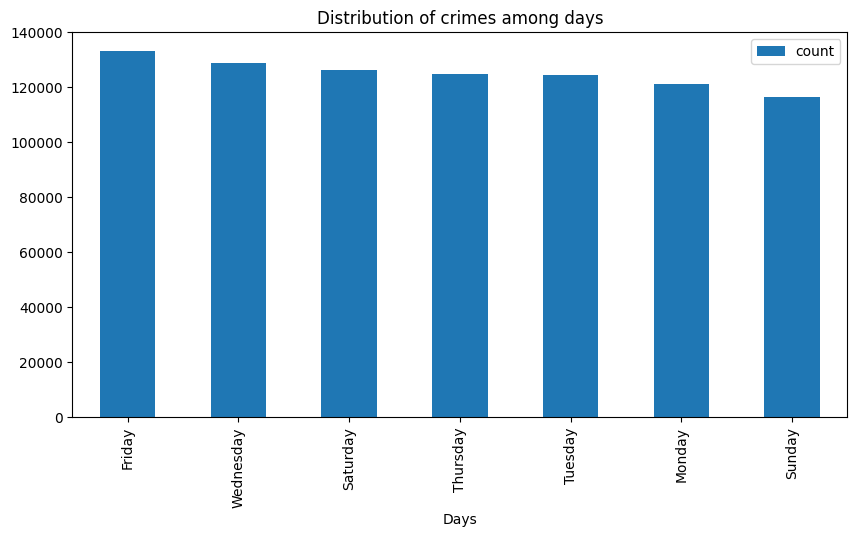

In [ ]:
def crime_distribution_among_days(df, plot = True):
    if plot:
        df.groupBy('DayOfWeek').count().orderBy('count', ascending=False).toPandas().plot(kind='bar', x='DayOfWeek', y='count', figsize=(10, 5))
        plt.title('Distribution of crimes among days')
        plt.xlabel('Days')
        plt.show()

crime_distribution_among_days(sfcrime_train, plot = plot)

### Trends of crimes during the week -- TODO: scrivere se si evidenzia qualche trend

In [ ]:
def weekly_trend(df, category):
    sfcrime_category = df[df['Category']==category]
    sfcrime_category.groupby(['DayOfWeek','Category'])\
                .agg({'Resolution':'count'})\
                .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
                .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
                .plot(kind='line',figsize=(8,5))
    plt.title('Weekly trend of the category: ' + category)
    plt.xlabel('Day of the week')
    plt.ylabel('Count')
    plt.show()

def plot_trend(df, category, plot = True):
    if plot:        
        weekly_trend(df, category)

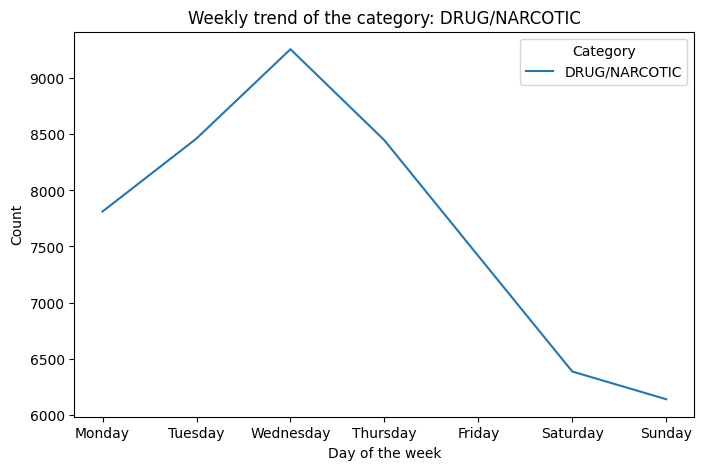

In [ ]:
plot_trend(sfcrime_train_pd, 'DRUG/NARCOTIC', plot = plot)

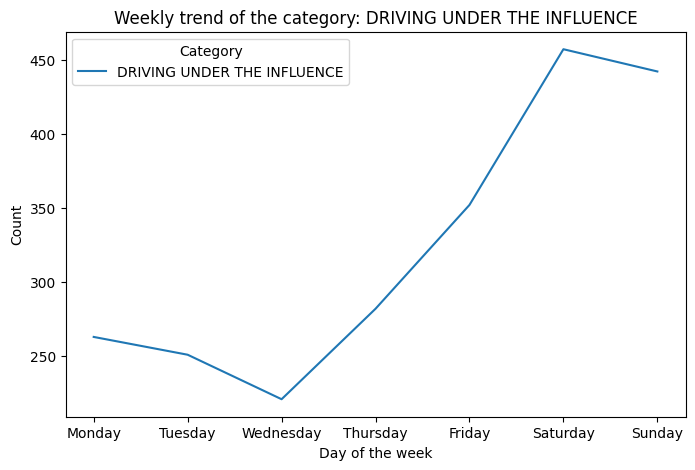

In [ ]:
plot_trend(sfcrime_train_pd, 'DRIVING UNDER THE INFLUENCE', plot = plot)

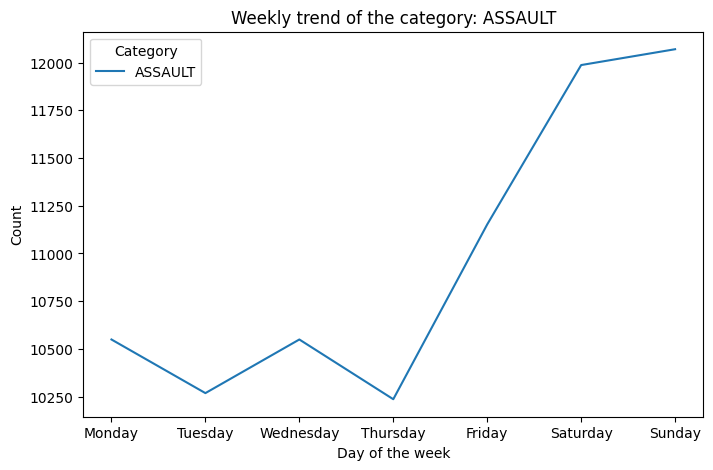

In [ ]:
plot_trend(sfcrime_train_pd, 'ASSAULT', plot = plot)

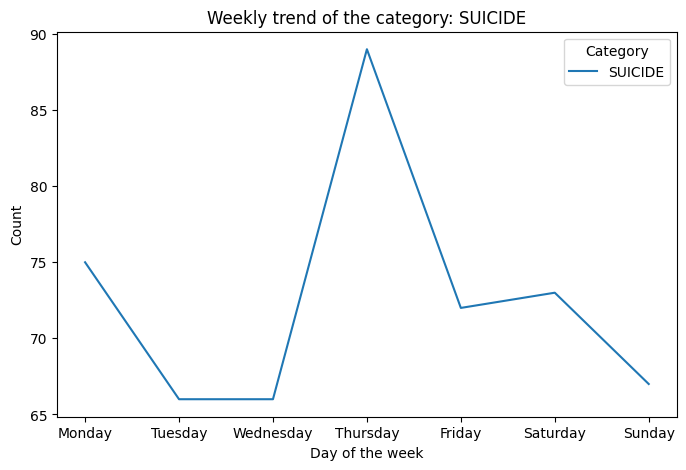

In [ ]:
plot_trend(sfcrime_train_pd, 'SUICIDE', plot = plot)

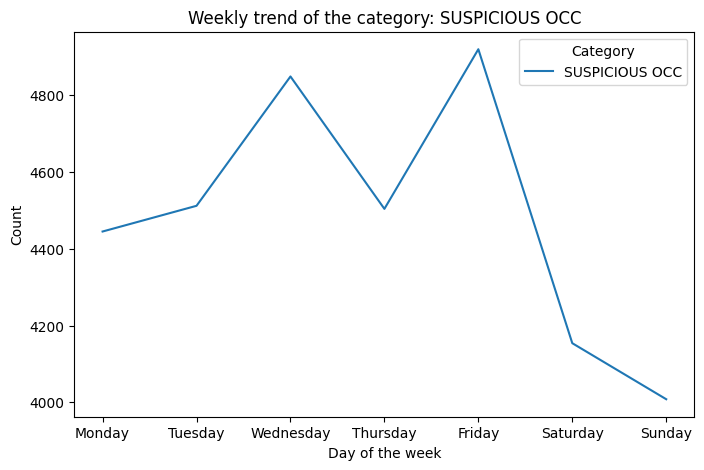

In [ ]:
plot_trend(sfcrime_train_pd, 'SUSPICIOUS OCC', plot = plot)

### Distribution of crimes among different addresses --- CHECK

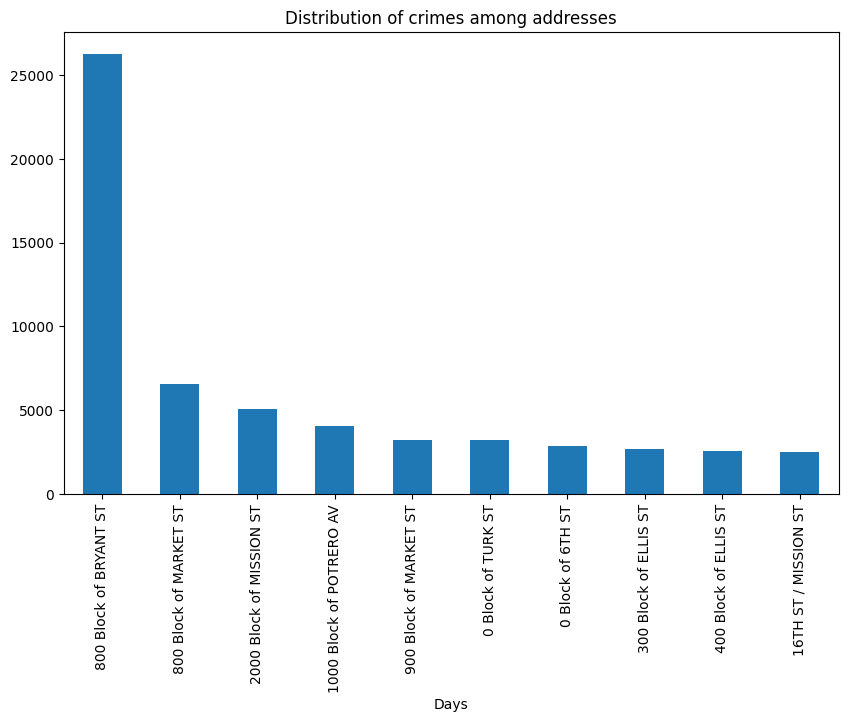

In [ ]:
def crime_distribution_among_addresses(df_top_10, plot = True):
    if plot:
        df_top_10['Address'].value_counts().head(10).plot(kind='bar',figsize=(10,6))
        plt.title('Distribution of crimes among addresses')
        plt.xlabel('Days')
        plt.show()

crime_distribution_among_addresses(sfcrime_train_top_10, plot = plot)

TODO: possiamo vedere che la maggior parte hanno la parola block quindi magari è importante ecc.. e si puo aggiungere come feauture togliendo l'address...........

### How the crimes have been resolved? --- TODO scrivere cosa si vede dai res

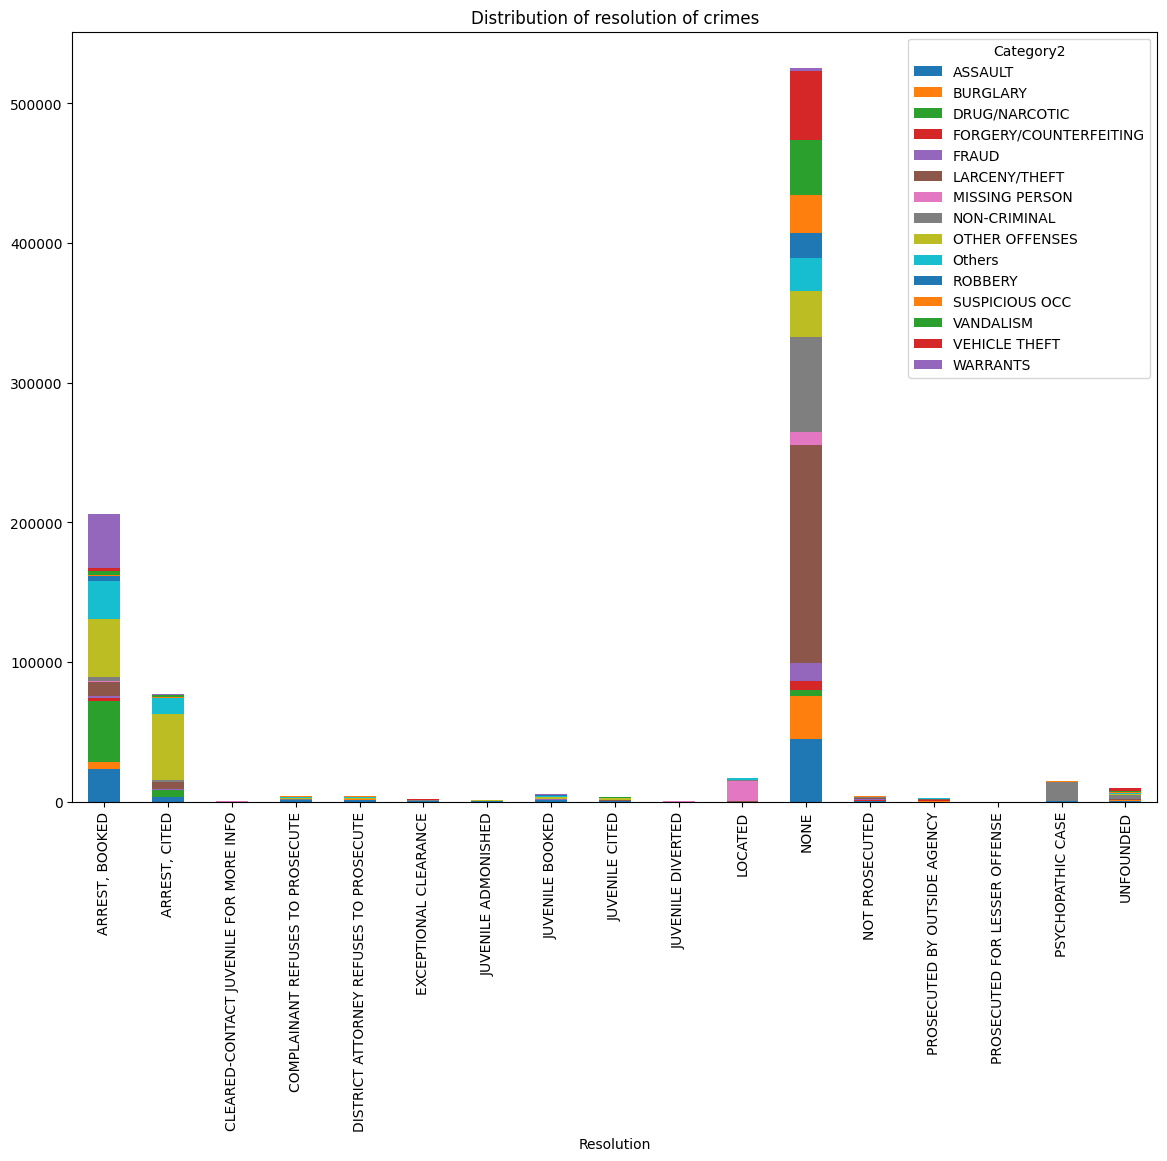

In [ ]:
def crime_distribution_resolution(df, plot = True):
    if plot:
        cats_relevant = df['Category'].value_counts()[df['Category'].value_counts() > 10000].index
        df['Category2'] = df['Category'].apply(lambda x: 'Others' if x not in cats_relevant else x)
        df['Category2'].unique()

        df.groupby(['Resolution','Category2']).\
            agg({'PdDistrict':'count'}).\
            pivot_table(index='Resolution',columns='Category2')['PdDistrict'].\
            plot(kind='bar',stacked=True,figsize=(14,10))

        plt.title('Distribution of resolution of crimes')
        plt.show()

crime_distribution_resolution(sfcrime_train_pd, plot = plot)

## Re-process the dataset after having inspected it: 
Pipeline:
- transform to categorical le colonne.......
- extract blocl feature ...
- tokenize descript...
- drop le altre colimns

In [44]:
# Transform columns to categorical
district_indexer = StringIndexer(inputCol="PdDistrict", outputCol="PdDistrict_cat")

category_indexer = StringIndexer(inputCol="Category", outputCol="Category_cat")


resolution_indexer = StringIndexer(inputCol="Resolution", outputCol="Resolution_cat")


day_indexer = StringIndexer(inputCol="DayOfWeek", outputCol="DayOfWeek_cat")
#sfcrime = indexer.fit(sfcrime).transform(sfcrime)

# Preprocess Descript column with tokenizer and count vector
regexTokenizer = Tokenizer(inputCol="Descript", outputCol="Descript_token")
vectorizer = CountVectorizer(inputCol="Descript_token", outputCol="Descript_vec")

#sfcrime = tokenizer.transform(sfcrime)

pipeline = Pipeline(stages=[district_indexer, category_indexer, resolution_indexer, day_indexer, regexTokenizer, vectorizer])
sfcrime = pipeline.fit(sfcrime).transform(sfcrime)

def drop_and_extract(sfcrime):
    # Drop no more needed columns
    sfcrime = sfcrime.drop("PdDistrict")\
            .drop("Category")\
            .drop("DayOfWeek")\
            .drop("Resolution")\
            .drop("Descript")\
            .drop("Descript_token")

    # Block feature extraction: 1 if block present, 0 otherwise
    sfcrime = sfcrime.withColumn('Block', when(sfcrime.Address.like("%Block%") , lit(1)).otherwise(lit(0)))

    # Drop the 'address' column since we already have (x, y) coordinates and the block feature
    sfcrime = sfcrime.drop("Address")

    return sfcrime

sfcrime = drop_and_extract(sfcrime)

In [45]:
sfcrime.show()

+-------------------+-------------------+------------------+----+-----+----+--------------+------------+--------------+-------------+--------------------+-----+
|              Dates|                  X|                 Y|Hour|Month|Year|PdDistrict_cat|Category_cat|Resolution_cat|DayOfWeek_cat|        Descript_vec|Block|
+-------------------+-------------------+------------------+----+-----+----+--------------+------------+--------------+-------------+--------------------+-----+
|2015-05-13 13:00:00|  -122.434361867112|  37.7911511886642|  13|    5|2015|           2.0|         8.0|           0.0|          1.0|(1086,[17,40,77],...|    1|
|2015-05-12 21:00:00|  -122.438642401146|  37.7216263690423|  21|    5|2015|           6.0|         5.0|           0.0|          4.0|(1086,[10,24],[1....|    0|
|2015-05-11 21:00:00|  -122.420307355721|37.788698951164704|  21|    5|2015|           2.0|         0.0|           0.0|          5.0|(1086,[0,2,3,4,5]...|    0|
|2015-05-11 19:07:00|-122.40391914

In [46]:
# save sfcrime
sfcrime.write.mode("overwrite").option("path", "bigdata/Project/dataset/sfcrime_processed").saveAsTable("sfcrime_processed")

23/12/30 10:13:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


In [3]:
# load sfcrime_train and sfcrime_test
sfcrime = spark.table("sfcrime_processed")

23/12/30 17:16:33 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/12/30 17:16:33 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/12/30 17:16:33 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/12/30 17:16:33 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.17.0.2


## Dataset requirements

In [47]:
print('Number of features: ', len(sfcrime.columns))

print('Total number of records: ', sfcrime.count())

print('Product of the number of features and the number of records: ', len(sfcrime.columns) * sfcrime.count())

Number of features:  12


Total number of records:  875659


Product of the number of features and the number of records:  10507908


# Models 

ESAME:
- GBT classifier (one vs rest) -> ok
- Decision Tree -> ok
- Bayesian -> ok
- Random forest -> ok
- logistic regression-> ok

PW:
- logistic regression TF-IDF [CHIARA]
- logistic regression (one vs rest)
- factorization machine (one vs rest) [GIORGIA]
- multilayer perceptron (va un po' male, troppi dati) [LIVIA]

FIX:
- pca (?)

In [4]:
# TODO: scrivere perche si fa rformula ?
rf = RFormula(formula="Category_cat ~ .")
rf_fit = rf.fit(sfcrime)
rf_transformed = rf_fit.transform(sfcrime)
rf_transformed.printSchema()

rf_sfcrime = rf_transformed.selectExpr("features", "label")


root
 |-- Hour: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- X_Scaled: vector (nullable = true)
 |-- Y_Scaled: vector (nullable = true)
 |-- PdDistrict_cat: double (nullable = true)
 |-- Category_cat: double (nullable = true)
 |-- Resolution_cat: double (nullable = true)
 |-- Descript_vec: vector (nullable = true)
 |-- DayOfWeek_cat: double (nullable = true)
 |-- Block: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)



Standardize features: Standardization is an important step in many machine learning algorithms, especially those that involve distance-based metrics or gradient-based optimization, as it helps ensure that all features have a similar scale.

In [ ]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(rf_sfcrime)
rf_sfcrime = scalerModel.transform(rf_sfcrime)

In [8]:
# Split the data into training and test sets (30% held out for testing)
(rf_sfcrime_train, rf_sfcrime_test) = rf_sfcrime.randomSplit([0.7, 0.3], seed=seed)

In [9]:
# TODO: scrivere a che serve ? a suddividere il carico
rf_sfcrime_train = rf_sfcrime_train.repartition(100)

In [12]:
# TODO: cross-validation



In [15]:
rf_sfcrime_train.show()

+--------------------+-----+--------------------+
|            features|label|      scaledFeatures|
+--------------------+-----+--------------------+
|(1095,[0,1,2,3,4,...|  0.0|[-0.5212396504484...|
|(1095,[0,1,2,3,4,...|  5.0|[-1.1320070951983...|
|(1095,[0,1,2,3,4,...|  2.0|[-1.7427745399482...|
|(1095,[0,1,2,3,4,...|  0.0|[-0.8266233728234...|
|(1095,[0,1,2,3,4,...|  2.0|[0.70029523905127...|
|(1095,[0,1,2,3,4,...|  2.0|[0.70029523905127...|
|(1095,[0,1,2,3,4,...|  0.0|[0.39491151667633...|
|(1095,[0,1,2,3,4,...| 12.0|[-0.2158559280735...|
|(1095,[0,1,2,3,4,...|  2.0|[1.00567896142620...|
|(1095,[0,1,2,3,4,...|  4.0|[1.46375454498860...|
|(1095,[0,1,2,3,4,...|  0.0|[0.54760337786380...|
|(1095,[0,1,2,3,4,...|  0.0|[0.70029523905127...|
|(1095,[0,1,2,3,4,...|  0.0|[1.31106268380114...|
|(1095,[0,1,2,3,4,...|  7.0|[-0.0631640668860...|
|(1095,[0,1,2,3,4,...|  7.0|[0.08952779430140...|
|(1095,[0,1,2,3,4,...|  7.0|[-0.3685477892609...|
|(1095,[0,1,2,3,4,...|  7.0|[-1.4373908175732...|


In [10]:
#Evaluation function for the models

def evaluation(results, model_name, oneVsRest = False):
    #compute accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(results)
    print("Accuracy of model %s = %g" % (model_name, accuracy))

    #compute F1 score
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1_score = evaluator.evaluate(results)
    print("F1 score of model %s = %g" % (model_name, f1_score))
    
    #compute logloss 
    if oneVsRest == False:
        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="logLoss")
        log_loss = evaluator.evaluate(results)
        print("Log Loss of model %s = %g" % (model_name, log_loss))
    
        return accuracy, log_loss, f1_score
    
    return accuracy, f1_score     

## Decision Tree Classifier

In [51]:
#TODO: hyperparameter tuning

dt_classifier = DecisionTreeClassifier()
dt_Tr = dt_classifier.fit(rf_sfcrime_train)

results_dt_train = dt_Tr.transform(rf_sfcrime_train)

23/12/30 10:14:52 WARN MemoryStore: Not enough space to cache rdd_418_16 in memory! (computed 5.4 MiB so far)
23/12/30 10:14:52 WARN MemoryStore: Not enough space to cache rdd_418_18 in memory! (computed 2.4 MiB so far)
23/12/30 10:14:52 WARN MemoryStore: Not enough space to cache rdd_418_21 in memory! (computed 2.4 MiB so far)
23/12/30 10:14:52 WARN MemoryStore: Not enough space to cache rdd_418_20 in memory! (computed 1594.5 KiB so far)
23/12/30 10:14:52 WARN MemoryStore: Not enough space to cache rdd_418_19 in memory! (computed 2.4 MiB so far)
23/12/30 10:14:52 WARN BlockManager: Persisting block rdd_418_20 to disk instead.
23/12/30 10:14:52 WARN BlockManager: Persisting block rdd_418_18 to disk instead.
23/12/30 10:14:52 WARN BlockManager: Persisting block rdd_418_19 to disk instead.
23/12/30 10:14:52 WARN BlockManager: Persisting block rdd_418_21 to disk instead.
23/12/30 10:14:52 WARN BlockManager: Persisting block rdd_418_16 to disk instead.
23/12/30 10:14:52 WARN MemoryStore: N

In [52]:
results_dt = dt_Tr.transform(rf_sfcrime_test)
#Evaluate the model
acc_dt, log_dt, f1_dt = evaluation(results_dt, 'Decision Tree')

Accuracy of model Decision Tree = 0.550245


F1 score of model Decision Tree = 0.476496


Log Loss of model Decision Tree = 1.46147


## Naive Bayes


In [ ]:
#TODO: hyperparameter tuning

In [15]:
#Classification with NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
nb_Tr = nb.fit(rf_sfcrime_train)

results_nb = nb_Tr.transform(rf_sfcrime_test)

In [17]:
acc_nb, log_nb, f1_nb = evaluation(results_nb, 'Naive Bayes')

23/12/28 15:47:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Accuracy of model Naive Bayes = 0.988648


Log Loss of model Naive Bayes = 0.0653669


F1 score of model Naive Bayes = 0.989284


## Logistic Regression

In [ ]:
#TODO: hyperparameter tuning

In [ ]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(rf_sfcrime_train)

results_lr = lrModel.transform(rf_sfcrime_test)

In [75]:
acc_lr, log_lr, f1_lr = evaluation(results_lr, 'Logistic Regression')

Accuracy of model Logistic Regression = 0.97992


Log Loss of model Logistic Regression = 0.509648


F1 score of model Logistic Regression = 0.974557


## Random forest

In [12]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures", numTrees=10)
rfModel = rf.fit(rf_sfcrime_train)

results_rf = rfModel.transform(rf_sfcrime_test)

23/12/30 17:19:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_114_17 in memory.
23/12/30 17:19:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_114_18 in memory.
23/12/30 17:19:07 WARN MemoryStore: Not enough space to cache rdd_114_17 in memory! (computed 384.0 B so far)
23/12/30 17:19:07 WARN BlockManager: Persisting block rdd_114_17 to disk instead.
23/12/30 17:19:07 WARN MemoryStore: Not enough space to cache rdd_114_18 in memory! (computed 384.0 B so far)
23/12/30 17:19:07 WARN BlockManager: Persisting block rdd_114_18 to disk instead.
23/12/30 17:19:07 WARN MemoryStore: Not enough space to cache rdd_114_16 in memory! (computed 12.6 MiB so far)
23/12/30 17:19:07 WARN BlockManager: Persisting block rdd_114_16 to disk instead.
23/12/30 17:19:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_114_19 in memory.
23/12/30 17:19:07 

In [13]:
acc_rf, log_rf, f1_rf = evaluation(results_rf, 'Random Forest')

Accuracy of model Random Forest = 0.685567


F1 score of model Random Forest = 0.649056


Log Loss of model Random Forest = 1.76518


## Prova MultiLayerPerceptron

In [21]:
# Compute input_size based on the assembled features
input_size = len(rf_sfcrime_train.select("features").first()[0])

In [ ]:
# Compute the number of classes
output_size = len(rf_sfcrime.select("label").distinct().collect())

In [7]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# specify layers for the neural network:
# input layer of size 1095 (features), one intermediate of size 100
# and output of size 39 (classes)
layers = [input_size, 100, output_size]

# train the model on scaled data since it prforms gradient-based optimization
trainer = MultilayerPerceptronClassifier(featuresCol='scaledFeatures', maxIter=100, layers=layers, blockSize=32, seed=1234)
model = trainer.fit(rf_sfcrime_train)


23/12/30 16:32:01 WARN MemoryStore: Not enough space to cache rdd_34_5 in memory! (computed 49.0 MiB so far)
23/12/30 16:32:02 WARN BlockManager: Persisting block rdd_34_5 to disk instead.
23/12/30 16:32:02 WARN MemoryStore: Not enough space to cache rdd_34_7 in memory! (computed 49.0 MiB so far)
23/12/30 16:32:02 WARN BlockManager: Persisting block rdd_34_7 to disk instead.
23/12/30 16:32:02 WARN MemoryStore: Not enough space to cache rdd_34_9 in memory! (computed 9.1 MiB so far)
23/12/30 16:32:02 WARN BlockManager: Persisting block rdd_34_9 to disk instead.
23/12/30 16:32:02 WARN MemoryStore: Not enough space to cache rdd_34_8 in memory! (computed 18.0 MiB so far)
23/12/30 16:32:02 WARN BlockManager: Persisting block rdd_34_8 to disk instead.
23/12/30 16:32:02 WARN MemoryStore: Not enough space to cache rdd_34_8 in memory! (computed 18.0 MiB so far)
23/12/30 16:32:02 WARN MemoryStore: Not enough space to cache rdd_34_7 in memory! (computed 49.0 MiB so far)
23/12/30 16:32:02 WARN Memo

In [8]:
results_mlp = model.transform(rf_sfcrime_test)
results_mlp.show()

23/12/30 17:07:07 WARN DAGScheduler: Broadcasting large task binary with size 1081.3 KiB


+--------------------+-----+--------------------+--------------------+--------------------+----------+
|            features|label|      scaledFeatures|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+----------+
|(1095,[0,1,2,3,4,...|  0.0|[-1.4349466134178...|[21.3065815787555...|[0.99999406959488...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[0.24315011245967...|[21.8344623619093...|[0.99999642933714...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[0.54825860807376...|[23.6484416438762...|[0.99999950748517...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[-0.2145126309614...|[23.4422271288174...|[0.99999952607248...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[0.24315011245967...|[21.4913135860426...|[0.99999602848978...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[0.24315011245967...|[22.8913172258954...|[0.99999914482448...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[0.24315011245967...|[22.2260039615684...|[0.

In [9]:
acc_mlp, log_mlp, f1_mlp = evaluation(results_mlp, 'MLP')

23/12/30 17:07:13 WARN DAGScheduler: Broadcasting large task binary with size 1077.0 KiB
23/12/30 17:07:19 WARN DAGScheduler: Broadcasting large task binary with size 1077.0 KiB


Accuracy of model MLP = 0.99955


23/12/30 17:07:26 WARN DAGScheduler: Broadcasting large task binary with size 1077.3 KiB


F1 score of model MLP = 0.999558


Log Loss of model MLP = 0.00117586


In [10]:
results_mlp.write.json("bigdata/BDA/results_mlp.json")

23/12/30 17:07:40 WARN DAGScheduler: Broadcasting large task binary with size 1294.2 KiB


In [11]:
#load the results from json file
results_mlp = spark.read.format("json")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path",f"bigdata/BDA/results_mlp.json/").load()

## Prova KNN

In [ ]:
#https://spark-packages.org/package/saurfang/spark-knn
#https://github.com/saurfang/spark-knn

In [19]:
'''from sparkknn.estimators import KNNClassifier
from pyspark.ml.feature import VectorAssembler

# Create the feature vector
assembler = VectorAssembler(inputCols=["X_Scaled", "Y_Scaled"], outputCol="features")
train_data = assembler.transform(sfcrime)
test_data = assembler.transform(sfcrime_test)

# Create the knn model
knn = KNNClassifier(k=10, topTreeSize=100, topTreeLeafSize=100)
knn_model = knn.fit(train_data)

# Make predictions
predictions = knn_model.transform(test_data)

predictions.select('prediction').show()'''

ModuleNotFoundError: No module named 'sparkknn'

## Logistic regression with TF-IDF features

In [ ]:
#https://spark.apache.org/docs/1.6.1/ml-features.html

In [67]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

hashingTF = HashingTF(inputCol="Descript_token", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="descript_features", minDocFreq=5) #minDocFreq: remove sparse terms

pipeline = Pipeline(stages=[district_indexer, category_indexer, resolution_indexer, day_indexer, regexTokenizer, hashingTF, idf])
sfcrime_tfidf = pipeline.fit(df_sfcrime).transform(df_sfcrime)
sfcrime_tfidf = drop_and_extract(sfcrime_tfidf)
sfcrime_tfidf = sfcrime_tfidf.drop("rawFeatures")

sfcrime_tfidf.show()

+----+-----+----+--------------------+--------------------+--------------+------------+--------------+-------------+--------------------+-----+
|Hour|Month|Year|            X_Scaled|            Y_Scaled|PdDistrict_cat|Category_cat|Resolution_cat|DayOfWeek_cat|   descript_features|Block|
+----+-----+----+--------------------+--------------------+--------------+------------+--------------+-------------+--------------------+-----+
|  13|    5|2015|[0.03937154402162...|[0.00159244193377...|           2.0|         8.0|           0.0|          1.0|(10000,[211,7402,...|    1|
|  21|    5|2015|[0.03724577693029...|[2.62895181373300...|           6.0|         5.0|           0.0|          4.0|(10000,[3802,6098...|    0|
|  21|    5|2015|[0.04635119131855...|[0.00154554696272...|           2.0|         0.0|           0.0|          5.0|(10000,[182,3590,...|    0|
|  19|    5|2015|[0.05448978141589...|[0.00151527753268...|           0.0|         0.0|           0.0|          5.0|(10000,[182,840,3...

In [68]:
rf_tfidf = rf.fit(sfcrime_tfidf).transform(sfcrime_tfidf)

rf_tfidf.printSchema()

rf_sfcrime_tfidf = rf_tfidf.selectExpr("features", "label")


rf_sfcrime_tfifd_train, rf_sfcrime_tfifd_test = rf_sfcrime_tfidf.randomSplit([0.7, 0.3], seed=seed)

rf_sfcrime_tfifd_train = rf_sfcrime_tfifd_train.repartition(100)

root
 |-- Hour: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- X_Scaled: vector (nullable = true)
 |-- Y_Scaled: vector (nullable = true)
 |-- PdDistrict_cat: double (nullable = false)
 |-- Category_cat: double (nullable = false)
 |-- Resolution_cat: double (nullable = false)
 |-- DayOfWeek_cat: double (nullable = false)
 |-- descript_features: vector (nullable = true)
 |-- Block: integer (nullable = false)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [60]:
#TODO: hyperparameter tuning

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(rf_sfcrime_tfifd_train)
results_lr_tfidf_test = lrModel.transform(rf_sfcrime_tfifd_test)


23/12/30 10:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1004.5 KiB
23/12/30 10:28:31 WARN DAGScheduler: Broadcasting large task binary with size 1005.6 KiB
23/12/30 10:28:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/30 10:28:32 WARN DAGScheduler: Broadcasting large task binary with size 1005.1 KiB
23/12/30 10:28:41 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
23/12/30 10:28:42 WARN DAGScheduler: Broadcasting large task binary with size 1005.1 KiB
23/12/30 10:28:43 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
23/12/30 10:28:43 WARN DAGScheduler: Broadcasting large task binary with size 1005.1 KiB
23/12/30 10:28:44 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
23/12/30 10:28:44 WARN DAGScheduler: Broadcasting large task binary with size 1005.1 KiB
23/12/30 10:28:45 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
23/

In [61]:
acc_lrtfidf, log_lrtfidf, f1_lrtfidf = evaluation(results_lr_tfidf_test, 'Logistic Regression with TF-IDF')

23/12/30 10:29:38 WARN DAGScheduler: Broadcasting large task binary with size 1418.7 KiB


Accuracy of model Logistic Regression with TF-IDF = 0.97889


23/12/30 10:30:00 WARN DAGScheduler: Broadcasting large task binary with size 1418.7 KiB


F1 score of model Logistic Regression with TF-IDF = 0.972875


23/12/30 10:30:17 WARN DAGScheduler: Broadcasting large task binary with size 1420.6 KiB
23/12/30 10:30:29 WARN DAGScheduler: Broadcasting large task binary with size 1421.6 KiB


Log Loss of model Logistic Regression with TF-IDF = 0.517908


## One-vs-rest (logistic regression)

In [10]:
from pyspark.ml.classification import LogisticRegression, OneVsRest

# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)

# train the multiclass model.
ovrModel = ovr.fit(rf_sfcrime_train)

results_lrovr = ovrModel.transform(rf_sfcrime_test)

23/12/29 11:23:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/29 11:38:03 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
23/12/29 11:38:22 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


In [11]:
acc_lrovr, f1_lgovr = evaluation(results_lrovr, 'Logistic Regression classififer with One vs Rest', oneVsRest = True)

23/12/29 11:39:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.5 KiB


+--------------------+-----+--------------------+----------+
|            features|label|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|(1095,[0,1,2,3,4,...|  0.0|[7.02981048520690...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[7.14663101563722...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[6.66787788052375...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[6.95078278347860...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[7.11284917747081...|       0.0|
|(1095,[0,1,2,3,4,...| 12.0|[-9.4434158870571...|      12.0|
|(1095,[0,1,2,3,4,...| 12.0|[-9.5998476457044...|      12.0|
|(1095,[0,1,2,3,4,...|  0.0|[16.1714164985704...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[12.1171184977287...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[9.06859132627398...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[10.2674956142979...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[6.83260222616011...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[11.5922084060359...|       0.0|
|(1095,[0,1,2,3,4,...|  

----------------------------------------                          (0 + 8) / 100]
Exception happened during processing of request from ('127.0.0.1', 33694)
Traceback (most recent call last):
  File "/usr/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/spark/python/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/spark/python/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/opt/spark/python/pyspark/accumulators.py", line 271, in accum_updates
    num_updates = read_int(self.rfile)
  File "/opt/spark

Py4JError: An error occurred while calling o10588.evaluate

## Prova Factorization Machines

In [22]:
# TODO: one vs rest

from pyspark.ml.classification import FMClassifier

fm = FMClassifier(stepSize=0.001)

# Create a Pipeline.
#pipeline = Pipeline(stages=[labelIndexer, featureScaler, fm])

# Train model.
model = fm.fit(rf_sfcrime_train)

# Make predictions.
predictions = model.transform(rf_sfcrime_test)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)


23/12/28 15:53:36 WARN BlockManager: Putting block rdd_396_2 failed due to exception java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 5.0.
23/12/28 15:53:36 WARN BlockManager: Block rdd_396_2 could not be removed as it was not found on disk or in memory
23/12/28 15:53:36 ERROR Executor: Exception in task 2.0 in stage 170.0 (TID 302)
java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 5.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at sca

Py4JJavaError: An error occurred while calling o1206.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 170.0 failed 1 times, most recent failure: Lost task 2.0 in stage 170.0 (TID 302) (b5aefea75be7 executor driver): java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 5.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1601)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1528)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1592)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.base/java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1293)
	at org.apache.spark.mllib.optimization.GradientDescent$.runMiniBatchSGD(GradientDescent.scala:216)
	at org.apache.spark.mllib.optimization.GradientDescent.optimizeWithLossReturned(GradientDescent.scala:154)
	at org.apache.spark.ml.regression.FactorizationMachines.trainImpl(FMRegressor.scala:155)
	at org.apache.spark.ml.regression.FactorizationMachines.trainImpl$(FMRegressor.scala:134)
	at org.apache.spark.ml.classification.FMClassifier.trainImpl(FMClassifier.scala:71)
	at org.apache.spark.ml.classification.FMClassifier.$anonfun$train$1(FMClassifier.scala:206)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.FMClassifier.train(FMClassifier.scala:179)
	at org.apache.spark.ml.classification.FMClassifier.train(FMClassifier.scala:71)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:78)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.base/java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Unknown Source)
Caused by: java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 5.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1601)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1528)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1592)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


## Gradient-Boosted Tree classifier with One-vs-Rest

In [32]:
#gradient boosted tree wth one vs rest
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
ovr = OneVsRest(classifier=gbt)
ovrModel = ovr.fit(rf_sfcrime_train)

results_gbtovr = ovrModel.transform(rf_sfcrime_test)


23/12/28 09:32:51 WARN MemoryStore: Not enough space to cache rdd_590_1 in memory! (computed 65.0 MiB so far)
23/12/28 09:32:51 WARN MemoryStore: Not enough space to cache rdd_590_0 in memory! (computed 98.3 MiB so far)
23/12/28 09:32:51 WARN MemoryStore: Not enough space to cache rdd_590_2 in memory! (computed 98.3 MiB so far)
23/12/28 09:32:51 WARN BlockManager: Persisting block rdd_590_0 to disk instead.
23/12/28 09:32:51 WARN BlockManager: Persisting block rdd_590_2 to disk instead.
23/12/28 09:32:51 WARN BlockManager: Persisting block rdd_590_1 to disk instead.
23/12/28 09:32:51 WARN MemoryStore: Not enough space to cache rdd_590_3 in memory! (computed 152.5 MiB so far)
23/12/28 09:32:51 WARN BlockManager: Persisting block rdd_590_3 to disk instead.
23/12/28 09:32:53 WARN MemoryStore: Not enough space to cache rdd_590_2 in memory! (computed 43.3 MiB so far)
23/12/28 09:32:53 WARN MemoryStore: Not enough space to cache rdd_590_2 in memory! (computed 8.2 MiB so far)
23/12/28 09:32:5

In [ ]:
acc_gbtovr, f1_gbtovr = evaluation(results_gbtovr, 'Gradient-Boosted tree classififer with One vs Rest', oneVsRest = True)

In [56]:
#save results in json format to avoid recomputing them (it takes an hour)
results_gbtovr.write.json("bigdata/BDA/results_gbtovr.json")

23/12/28 11:13:26 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


In [57]:
#load the results from json file
results_lrovr = spark.read.format("json")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path",f"bigdata/BDA/results_gbtovr.json/").load()

In [58]:
#test that the results are loaded correctly
results_lrovr.show()

+--------------------+-----+----------+--------------------+
|            features|label|prediction|       rawPrediction|
+--------------------+-----+----------+--------------------+
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  5.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  

### Commenti: 
funziona ma ci mette un sacco (per questo ho salvato i risultati). I risultati sono molto buoni (accuracy 99,5%) ma considerando che il train ci mette quasi un'ora meglio altri classifiers tipo naive bayes che ci mette 5 secondi (accurcay 98,8%) e su cui comunque si può fare tuning dei parametri o cross validation per migliorare. Problema sull'evaluation: one-vs-rest non restituisce la colonna probbilities che serve per calcolare la logloss, quindi la funzione che abbiamo fatto per l'evaluation non funziona (magari si può pensare di modificarla e di passare un flag che dice se deve calcolare log loss o no)

# PCA

In [65]:
pca = PCA(k=2, inputCol="features")
pca.setOutputCol("pca_features")
model = pca.fit(rf_sfcrime_train)
sfcrime_pca_train = model.transform(rf_sfcrime_train)

#stessa trasformazione da applicare anche al validation?
#https://stats.stackexchange.com/questions/142216/zero-centering-the-testing-set-after-pca-on-the-training-set
sfcrime_pca_val = model.transform(rf_sfcrime_val)

In [66]:
sfcrime_pca_train.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------+-----+-----------------------------------------+
|features                                                                                                                        |label|pca_features                             |
+--------------------------------------------------------------------------------------------------------------------------------+-----+-----------------------------------------+
|(1095,[0,1,2,3,4,5,6,7,8,9,11,14],[9.0,7.0,2006.0,0.6219893339215445,0.6091207637881557,2.0,1.0,5.0,1.0,1.0,1.0,1.0])           |0.0  |[0.3683651146610864,-1886.54460884121]   |
|(1095,[0,1,2,3,4,5,6,7,8,9,11,14],[15.0,1.0,2008.0,0.3525884499242813,0.670919143060952,9.0,1.0,1.0,1.0,1.0,1.0,1.0])           |0.0  |[-5.665206773112289,-1890.43784689985]   |
|(1095,[0,1,2,3,4,5,6,7,8,9,11,14],[22.0,3.0,2006.0,0.6743842035748872,0.7117503097244482,4.0,3.0,7.0,1.0

In [ ]:
#TODO: provare a ripetere classification con PCA in tutti i modelli

##### Decision Tree

In [22]:
dt_classifier_pca = DecisionTreeClassifier()
dt_Tr_pca = dt_classifier_pca.fit(sfcrime_pca_train)
dt_Tr_pca = dt_Tr_pca.setFeaturesCol("features")

23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_15 in memory! (computed 1594.5 KiB so far)
23/12/19 09:00:08 WARN BlockManager: Persisting block rdd_406_15 to disk instead.
23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_17 in memory! (computed 19.0 MiB so far)
23/12/19 09:00:08 WARN BlockManager: Persisting block rdd_406_17 to disk instead.
23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_18 in memory! (computed 5.4 MiB so far)
23/12/19 09:00:08 WARN BlockManager: Persisting block rdd_406_18 to disk instead.
23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_19 in memory! (computed 3.6 MiB so far)
23/12/19 09:00:08 WARN BlockManager: Persisting block rdd_406_19 to disk instead.
23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_17 in memory! (computed 8.2 MiB so far)
23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_18 in memory! (computed 19.0 MiB so far)
23/12/1

In [30]:
results_dt_pca = dt_Tr_pca.transform(sfcrime_pca_val)

In [27]:
results_dt_pca.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
| 12.0|      12.0|
| 12.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
| 29.0|      29.0|
| 12.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



##### Naive Bayes

In [67]:
#Classification with NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
nb_Tr = nb.fit(sfcrime_pca_train)

results_nb_val = nb_Tr.transform(sfcrime_pca_val)

In [68]:
results_nb_val.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|      12.0|
|  0.0|       0.0|
|  0.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|      12.0|
|  0.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|      12.0|
+-----+----------+
only showing top 20 rows



In [69]:
#evaluate the model
evaluation(results_nb_val, 'Naive Bayes with PCA')

Accuracy of model Naive Bayes with PCA = 0.988435


Log Loss of model Naive Bayes with PCA = 0.0654334


F1 score of model Naive Bayes with PCA = 0.989161


Commenti: i risultati sono esattamente gli stessi sia in termini di accuracy che di loss, anche settando diverse dimensioni per pca -> capire perchè succede

##### Logistic Regressor

In [70]:
#logistic regression with PCA
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(sfcrime_pca_train)

results_lr_val = lrModel.transform(sfcrime_pca_val)

In [71]:
results_lr_val.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [72]:
evaluation(results_lr_val, 'Logistic Regression with PCA')

Accuracy of model Logistic Regression with PCA = 0.97992


Log Loss of model Logistic Regression with PCA = 0.509648


F1 score of model Logistic Regression with PCA = 0.974557


##### Random forest

In [76]:
#random forest with PCA
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rfModel = rf.fit(sfcrime_pca_train)

results_rf_val = rfModel.transform(sfcrime_pca_val)

23/12/28 11:26:58 WARN MemoryStore: Not enough space to cache rdd_11347_1 in memory! (computed 100.2 MiB so far)
23/12/28 11:26:58 WARN BlockManager: Persisting block rdd_11347_1 to disk instead.
23/12/28 11:26:58 WARN MemoryStore: Not enough space to cache rdd_11347_3 in memory! (computed 12.6 MiB so far)
23/12/28 11:26:58 WARN BlockManager: Persisting block rdd_11347_3 to disk instead.
23/12/28 11:26:58 WARN MemoryStore: Not enough space to cache rdd_11347_2 in memory! (computed 12.6 MiB so far)
23/12/28 11:26:58 WARN BlockManager: Persisting block rdd_11347_2 to disk instead.
23/12/28 11:26:58 WARN MemoryStore: Not enough space to cache rdd_11347_0 in memory! (computed 66.3 MiB so far)
23/12/28 11:26:58 WARN BlockManager: Persisting block rdd_11347_0 to disk instead.
23/12/28 11:27:00 WARN MemoryStore: Not enough space to cache rdd_11347_1 in memory! (computed 155.5 MiB so far)
23/12/28 11:27:00 WARN MemoryStore: Not enough space to cache rdd_11347_3 in memory! (computed 29.4 MiB so

In [77]:
results_rf_val.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [78]:
evaluation(results_rf_val, 'Random Forest with PCA')

Accuracy of model Random Forest with PCA = 0.590899


Log Loss of model Random Forest with PCA = 1.82718


F1 score of model Random Forest with PCA = 0.554549


##### Gradient-Boosted tree with one-vs-rest

In [ ]:
#gradient boosted tree wth one vs rest
gbt = GBTClassifier(labelCol="label", featuresCol="pca_features", maxIter=10)
ovr = OneVsRest(classifier=gbt)
ovrModel = ovr.fit(sfcrime_pca_train)

results_gbtovr = ovrModel.transform(sfcrime_pca_val)

In [ ]:
results_gbtovr.show()